# Plot the DAG of the learned Bayesian network

## 1. Description

Here, I plot the directed acyclic graph of my Bayesian Network to showcase its structure.

To illustrate the dependencies among different variables, I will condition the size of each edge based on the value of the log-likelihood tests. This will enable me to show which variables are more strongly related. 

## 2. Prepare the session

I start by loading the different libraries

In [1]:
# To manipulate data
import pandas as pd

# Plotting librairies
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

Import the model output and independence tests output files.

In [2]:
from joblib import load
import os

# Define the parent directory
parent_dir = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir)
)

# Define the subfolder directory
output_folder = os.path.join(
    parent_dir, "outputs"
)

# Name of the model output file
file_name1 = "BayesNet-fit.joblib"
file_name2 = "BayesNet-IndTests.joblib"

model = load(
    os.path.join(
        output_folder,
        file_name1
    )
)

tests_df = load(
    os.path.join(
        output_folder,
        file_name2
    )
)

## 3. Display the results

### 3.1 Display the independence tests results

Display the results of the log likelihood ratio tests for edges to accompany the graph

In [4]:
tests_df.head(n = 16)

,Source_node,Target_node,Log_likelihood,P_value,Degrees_of_freedom
0,prior_chases_persec_bin,pred_speed_bin,606.782448,5.275914e-130,4
1,pred_speed_bin,chases_persec_bin,606.782448,5.275914e-130,4
2,pred_speed_bin,prey_avg_speed_bin,1263.728949,2.432518e-272,4
3,pred_speed_bin,prey_captured,1485.103528,0.000000e+00,2
4,prior_prey_captured,pred_speed_bin,283.509207,2.733744e-62,2
5,prior_prey_speed_bin,pred_speed_bin,242.331570,2.919563e-51,4
6,iqrange_prey_speed_bin,pred_speed_bin,45.773040,2.625179e-07,8
7,xp_level,pred_speed_bin,184.111950,9.757583e-39,4
8,xp_level,chases_persec_bin,1248.166708,5.754147e-269,4
9,time_lag_session_log_bin,pred_speed_bin,66.854636,2.071942e-11,8


### 3.2 Plot the DAG

The normalization used to compute the edge strength is performed as such :

$
normalized \ log \ likelihood = \frac{logL \ value - min \ logL \ value}{max \ logL \ value - min \ logL \ value}
$

Where :
- $logL \ value$ is the log likelihood test statistic value for a given edge.
- $min \ logL \ value$ is the minimum log likelihood test statistic value observed across all edges.
- $max \ logL \ value$ is the maximum log likelihood test statistic value observed across all edges.
- $normalized \ log \ likelihood$ is the normalized value within the range [0, 1].

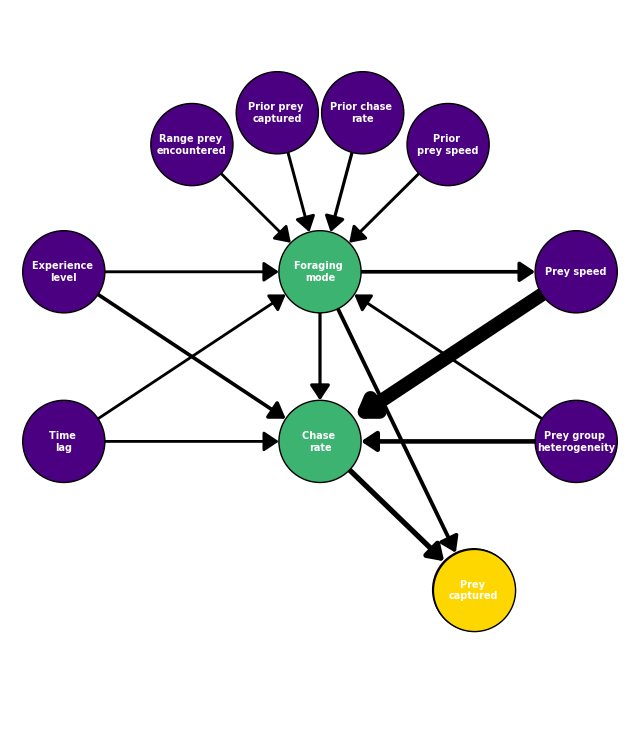

In [3]:
# Initialize an empty graph
G = nx.DiGraph()

# Rename the nodes
node_mapping = {
    "pred_speed_bin": "Foraging \nmode",
    #"hunting_success": "Hunting\nsuccess",
    "prey_captured": "Prey \ncaptured",
    "prey_avg_speed_bin": "Prey speed",
    "prey_var_speed_log_bin": "Prey group \nheterogeneity",
    "iqrange_prey_speed_bin": "Range prey \nencountered",
    "prior_prey_speed_bin": "Prior \nprey speed",
    #"prior_success": "Prior\nhunting\nsuccess",
    "prior_prey_captured": "Prior prey \ncaptured",
    "chases_persec_bin": "Chase \nrate",
    "time_lag_session_log_bin": "Time \nlag",
    "xp_level": "Experience \nlevel",
    "prior_chases_persec_bin": "Prior chase \nrate"
}

# Define positions for the nodes
pos = {
    "Experience \nlevel": (0.7, 0),
    "Time \nlag": (0.7, -0.008),
    #"Range prey \nencountered": (0.76, 0.005),
    #"Prior\nhunting\nsuccess": (0.9, 0.007),
    
    "Range prey \nencountered": (0.85, 0.006),
    "Prior prey \ncaptured": (0.95, 0.0075),
    "Prior chase \nrate": (1.05, 0.0075),
    "Prior \nprey speed": (1.15, 0.006),
    
    "Foraging \nmode": (1, 0),
    
    "Prey speed": (1.3, 0),
    "Prey group \nheterogeneity": (1.3, -0.008),

    "Chase \nrate": (1, -0.008),
    #"Hunting\nsuccess": (1.18, -0.015),
    "Prey \ncaptured": (1.18, -0.015)
}

# Add nodes to the graph
G.add_nodes_from(node_mapping.values())

# Iterate through the results dataframe to use arrow widths for edge strength
for _, row in tests_df.iterrows():
    source_node = node_mapping[row["Source_node"]]
    target_node = node_mapping[row["Target_node"]]
    test_statistic = row["Log_likelihood"]
    
    # Normalize the test statistic to be between 0 and 1
    normalized_statistic = (test_statistic - tests_df["Log_likelihood"].min()) / (
            tests_df["Log_likelihood"].max() - tests_df["Log_likelihood"].min())
    
    # Assign strength based on the normalized test statistic
    strength = normalized_statistic
    
    # Add edge to the graph
    G.add_edge(source_node, target_node, weight = strength)

# Retrieve the Markov blanket nodes for hunting success / prey captured
#original_markov_blanket_nodes = model.get_markov_blanket("hunting_success")
original_markov_blanket_nodes = model.get_markov_blanket("prey_captured")

# Map the original node names to the renamed nodes in the graph
markov_blanket_nodes = [node_mapping[node] for node in original_markov_blanket_nodes]

# Modify node colors to identify Markov blanket nodes
node_colors = ["mediumseagreen" if node in markov_blanket_nodes else "indigo" for node in G.nodes]

# Plot size
plt.figure(figsize = (8, 9.5))

# Draw the DAG with different arrow widths based on edge strength
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size = 3500,
    edge_color = "black",
    arrowstyle = "-|>, head_width=0.6,head_length=0.9",
    # Base factor (2). I can play with the scaling factor (8)
    width = [2 + 8 * G[u][v]["weight"] for u, v in G.edges()]
)

# Draw the nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_size = 3500,
    node_color = node_colors,
    edgecolors = "black"
)

# Draw the "Hunting\nsuccess" node with a different color
nx.draw_networkx_nodes(
    G,
    pos,
    #nodelist=["Hunting\nsuccess"],
    nodelist = ["Prey \ncaptured"],
    node_size = 3500,
    node_color = "gold",
    edgecolors = "black"
)

# Draw the node labels
nx.draw_networkx_labels(
    G,
    pos,
    font_size = 7,
    font_weight = "bold",
    font_color = "white"
)

# Display the figure
plt.axis("off")
plt.show()